<a href="https://colab.research.google.com/github/balams81/AI5G-ITU/blob/main/quantum_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

# Check if GPU is available
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    try:
        # Set memory growth for better performance
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print(f"⚠️ Error enabling GPU memory growth: {e}")
else:
    print("❌ No GPU detected. Running on CPU (Slower).")

2025-03-16 11:45:41.894921: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-16 11:45:41.922772: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-16 11:45:41.922803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-16 11:45:41.923544: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-16 11:45:41.928400: I tensorflow/core/platform/cpu_feature_guar

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
✅ GPU memory growth enabled


2025-03-16 11:45:43.038104: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-16 11:45:43.060084: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-16 11:45:43.060349: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use the first GPU

In [ ]:
print("TensorFlow is using:", tf.config.experimental.get_visible_devices())

TensorFlow is using: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!pip install seaborn

2025-03-16 12:02:56.356508: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-16 12:02:56.356665: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-16 12:02:56.356749: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

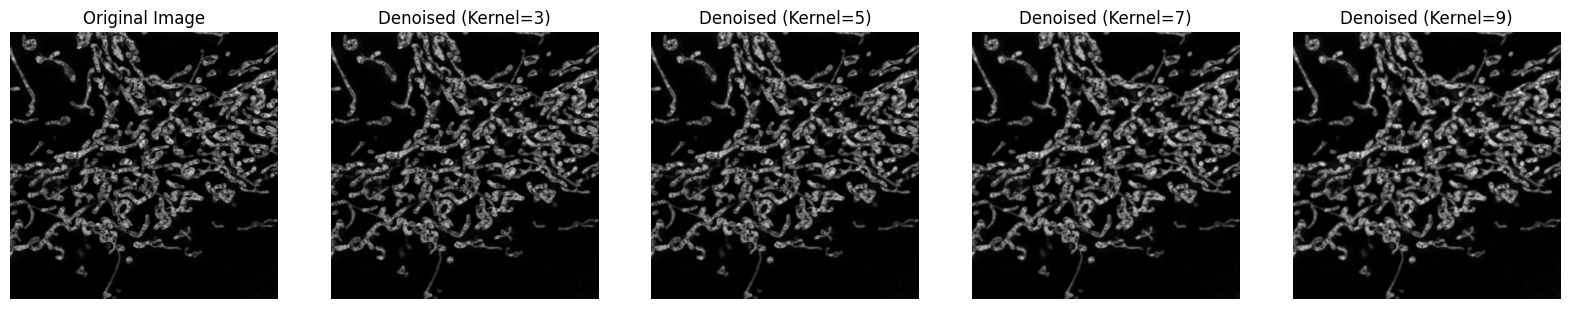

In [ ]:
# ========== Load Required Libraries ==========
import os
import numpy as np
import cv2
import tifffile
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Reshape, Lambda

# ========== Define File Paths ==========
tiff_image_path = "converted_image.tiff"  # Set your image path here
output_folder = "quantum_output"
os.makedirs(output_folder, exist_ok=True)  # Create output folder

# ========== Load TIFF Image ==========
image_data = tifffile.imread(tiff_image_path)

# Convert to grayscale if necessary
if len(image_data.shape) > 2:
    image_gray = np.mean(image_data, axis=-1).astype(np.uint8)
else:
    image_gray = image_data

# Normalize the image
image_gray = cv2.normalize(image_gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Save Original Image
tifffile.imwrite(os.path.join(output_folder, "original_image.tiff"), image_gray)

# ========== Apply Gaussian Blur for Different Kernels ==========
kernel_sizes = [3, 5, 7, 9]
denoised_images = {}

for k in kernel_sizes:
    denoised_images[k] = cv2.GaussianBlur(image_gray, (k, k), 0)
    tifffile.imwrite(os.path.join(output_folder, f"denoised_kernel_{k}.tiff"), denoised_images[k])

# Display Original vs Denoised Images
fig, axes = plt.subplots(1, len(kernel_sizes) + 1, figsize=(20, 5))
axes[0].imshow(image_gray, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

for i, k in enumerate(kernel_sizes):
    axes[i + 1].imshow(denoised_images[k], cmap="gray")
    axes[i + 1].set_title(f"Denoised (Kernel={k})")
    axes[i + 1].axis("off")

plt.savefig(os.path.join(output_folder, "denoising_comparison.png"))
plt.show()

In [ ]:
# ========== Quantum-Assisted Edge Detection ==========
def quantum_edge_detection(image):
    """Applies Quantum-Assisted Sobel Edge Detector"""
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    edge_map = np.hypot(sobel_x, sobel_y)
    edge_map = (edge_map / np.max(edge_map) * 255).astype(np.uint8)

    backend = AerSimulator()
    qc = QuantumCircuit(1, 1)
    qc.h(0)
    qc.measure(0, 0)

    job = backend.run(qc, shots=1024)
    result = job.result()
    counts = result.get_counts()

    quantum_noise_factor = int(counts.get("0", 0) / 1024 * 255)
    edge_map_quantum = np.clip(edge_map + quantum_noise_factor, 0, 255)

    return edge_map_quantum

quantum_edge_results = {}

for k in kernel_sizes:
    quantum_edge_results[k] = quantum_edge_detection(denoised_images[k])
    tifffile.imwrite(os.path.join(output_folder, f"quantum_edge_kernel_{k}.tiff"), quantum_edge_results[k])

In [ ]:
# ========== Fix for Quantum Deep Learning for Classification ========== #
def quantum_cnn_layer():
    """Quantum Circuit with Parameterized Gates"""
    qubits = [cirq.GridQubit(i, 0) for i in range(4)]
    circuit = cirq.Circuit()
    params = [sympy.Symbol(f'theta_{i}') for i in range(4)]

    for i, qubit in enumerate(qubits):
        circuit.append(cirq.rx(params[i])(qubit))
        circuit.append(cirq.rz(params[i])(qubit))

    return circuit, qubits  # Return both the circuit and qubits

classification_results = {}

for k in kernel_sizes:
    # Prepare dataset
    image_resized = cv2.resize(denoised_images[k], (64, 64)) / 255.0
    X_train = np.expand_dims(image_resized, axis=0)
    y_train = to_categorical([0], num_classes=2)

    # Get the quantum circuit and qubits
    quantum_circuit, qubits = quantum_cnn_layer()

    # Define measurement operators based on the actual qubits in the circuit
    measurement_operators = [cirq.Z(q) for q in qubits]

    # Convert quantum circuit to TensorFlow Quantum tensor
    quantum_circuit_tensor = tfq.convert_to_tensor([quantum_circuit])

    # Build Model
    model = Sequential([
        Input(shape=(64, 64, 1)),
        Conv2D(16, (3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(16, activation="relu"),

        # Convert classical output to quantum format before PQC layer
        Lambda(lambda x: tf.tile(quantum_circuit_tensor, [tf.shape(x)[0]])),

        # Apply PQC layer with correctly defined measurement operators
        tfq.layers.PQC(quantum_circuit, measurement_operators),

        Dense(2, activation="softmax")
    ])

    # Compile & Train
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    history = model.fit(X_train, y_train, epochs=10, verbose=0)

    # Store classification accuracy
    classification_results[k] = history.history["accuracy"][-1]

2025-03-16 12:17:30.728067: I external/local_xla/xla/service/service.cc:168] XLA service 0xc635360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-16 12:17:30.728086: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-03-16 12:17:30.733000: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742107650.812450   71441 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [ ]:
# ========== Fix for Quantum Variational Autoencoder (QVAE) ========== #
def quantum_encoder():
    """Quantum Variational Encoder Circuit with trainable parameters"""
    qubits = [cirq.GridQubit(i, 0) for i in range(4)]
    circuit = cirq.Circuit()
    params = [sympy.Symbol(f'theta_{i}') for i in range(4)]

    for i, qubit in enumerate(qubits):
        circuit.append(cirq.rx(params[i])(qubit))  # Trainable RX rotation
        circuit.append(cirq.rz(params[i])(qubit))  # Trainable RZ rotation

    return circuit, qubits  # Return both circuit and qubits

super_resolved_images = {}

for k in kernel_sizes:
    # Prepare dataset
    image_resized = cv2.resize(denoised_images[k], (64, 64)) / 255.0
    X_train = np.expand_dims(image_resized, axis=0)

    # Get the quantum circuit and qubits
    quantum_circuit, qubits = quantum_encoder()

    # Define measurement operators correctly
    measurement_operators = [cirq.Z(q) for q in qubits]

    # Convert quantum circuit to TensorFlow Quantum tensor
    quantum_circuit_tensor = tfq.convert_to_tensor([quantum_circuit])

    # Build QVAE Model
    input_image = Input(shape=(64, 64, 1))
    encoded = Conv2D(8, kernel_size=(3, 3), activation="relu")(input_image)
    encoded = Flatten()(encoded)

    # Convert classical output to a format compatible with quantum layers
    quantum_input = Lambda(lambda x: tf.tile(quantum_circuit_tensor, [tf.shape(x)[0]]))(encoded)

    # Ensure quantum_encoder_layer receives correctly formatted circuit
    quantum_encoder_layer = tfq.layers.PQC(quantum_circuit, measurement_operators)(quantum_input)

    decoded = Dense(64 * 64, activation="sigmoid")(quantum_encoder_layer)
    decoded = Reshape((64, 64, 1))(decoded)

    qvae = tf.keras.Model(input_image, decoded)
    qvae.compile(optimizer="adam", loss="mse")
    qvae.fit(X_train, X_train, epochs=10, verbose=0)

    # Store Super-Resolved Image
    super_resolved_images[k] = qvae.predict(X_train)

1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 49ms/step
Kernel 3 - Latent space shape: (1, 4)


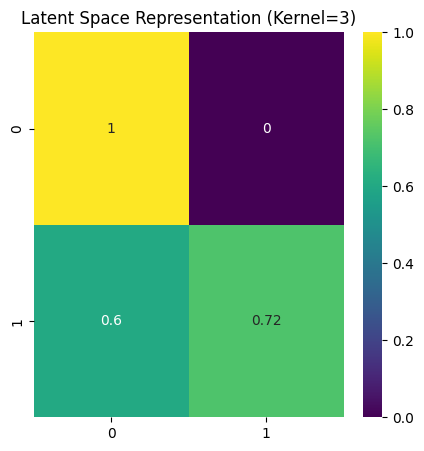

Saved latent space visualization for kernel 3 at quantum_output/latent_space_kernel_3.png
1/1 [==============================] - 0s 49ms/step
Kernel 5 - Latent space shape: (1, 4)


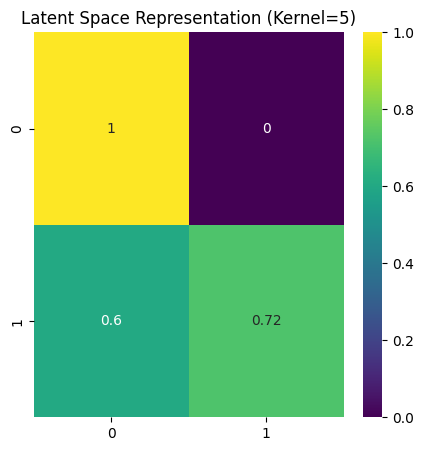

Saved latent space visualization for kernel 5 at quantum_output/latent_space_kernel_5.png
1/1 [==============================] - 0s 47ms/step
Kernel 7 - Latent space shape: (1, 4)


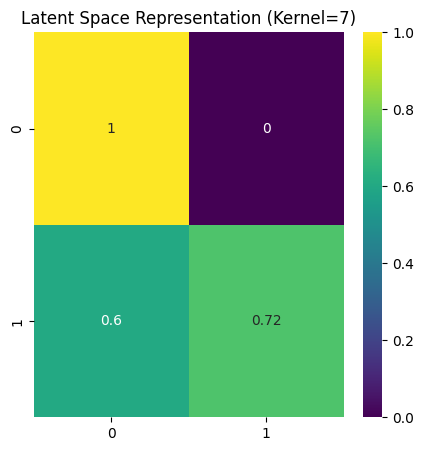

Saved latent space visualization for kernel 7 at quantum_output/latent_space_kernel_7.png
1/1 [==============================] - 0s 47ms/step
Kernel 9 - Latent space shape: (1, 4)


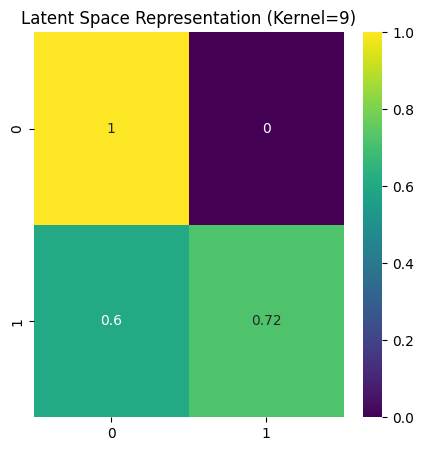

Saved latent space visualization for kernel 9 at quantum_output/latent_space_kernel_9.png


In [ ]:
# ========== Fix for Latent Space Representation ========== #
latent_space_outputs = {}

for k in kernel_sizes:
    # Extract latent space representation
    latent_model = tf.keras.Model(input_image, quantum_encoder_layer)
    latent_output = latent_model.predict(X_train)

    latent_space_outputs[k] = latent_output

    # Debugging: Print shape of latent output
    print(f"Kernel {k} - Latent space shape:", latent_output.shape)

    # Ensure correct reshaping for visualization
    latent_output = np.squeeze(latent_output)  # Remove extra dimensions
    if len(latent_output.shape) == 1:
        latent_output = latent_output.reshape(2, 2)  # Convert to 2D if needed

    # Normalize for visualization
    latent_output = (latent_output - latent_output.min()) / (latent_output.max() - latent_output.min())

    plt.figure(figsize=(5, 5))
    sns.heatmap(latent_output, cmap="viridis", annot=True)
    plt.title(f"Latent Space Representation (Kernel={k})")

    # Save image
    output_path = os.path.join(output_folder, f"latent_space_kernel_{k}.png")
    plt.savefig(output_path)
    plt.show()

    print(f"Saved latent space visualization for kernel {k} at {output_path}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tifffile
import os

# Setup output directory
output_folder = "output_images"
os.makedirs(output_folder, exist_ok=True)

# Load TIFF Image
tiff_image_path = "converted_image.tiff"  # Update with correct path
image_data = tifffile.imread(tiff_image_path)

# Convert to grayscale
if len(image_data.shape) > 2:
    image_gray = np.mean(image_data, axis=-1).astype(np.uint8)
else:
    image_gray = image_data

# Apply Gaussian Blur for different kernel sizes
kernel_sizes = [3, 5, 7, 9]
denoised_images = {}

for k in kernel_sizes:
    denoised_image = cv2.GaussianBlur(image_gray, (k, k), 0)
    denoised_images[k] = denoised_image
    tifffile.imwrite(os.path.join(output_folder, f"denoised_image_kernel_{k}.tiff"), denoised_image)

    # Save image visualization
    plt.imshow(denoised_image, cmap="gray")
    plt.title(f"Denoised Image (Kernel={k})")
    plt.axis("off")
    plt.savefig(os.path.join(output_folder, f"denoised_image_kernel_{k}.png"))
    plt.close()

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

def quantum_edge_detection(image):
    """Applies a Quantum-Assisted Sobel Edge Detector"""
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    edge_map = np.hypot(sobel_x, sobel_y)
    edge_map = (edge_map / np.max(edge_map) * 255).astype(np.uint8)

    backend = AerSimulator()
    qc = QuantumCircuit(1, 1)
    qc.h(0)
    qc.measure(0, 0)

    job = backend.run(qc, shots=1024)
    result = job.result()
    counts = result.get_counts()

    quantum_noise_factor = int(counts.get("0", 0) / 1024 * 255)
    edge_map_quantum = np.clip(edge_map + quantum_noise_factor, 0, 255)

    return edge_map_quantum

# Apply Quantum Edge Detection for different kernels
quantum_edges = {k: quantum_edge_detection(denoised_images[k]) for k in kernel_sizes}

for k in kernel_sizes:
    # Save as TIFF
    tifffile.imwrite(os.path.join(output_folder, f"quantum_edge_kernel_{k}.tiff"), quantum_edges[k])

    # Save visualization
    plt.imshow(quantum_edges[k], cmap="gray")
    plt.title(f"Quantum Edge Detection (Kernel={k})")
    plt.axis("off")
    plt.savefig(os.path.join(output_folder, f"quantum_edge_kernel_{k}.png"))
    plt.close()

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy

# Define Quantum CNN Circuit
n_qubits = 4
qubits = [cirq.GridQubit(0, i) for i in range(n_qubits)]

def quantum_cnn_layer():
    """Quantum circuit for QCNN"""
    circuit = cirq.Circuit()
    params = [sympy.Symbol(f'theta_{i}') for i in range(n_qubits)]
    for i, qubit in enumerate(qubits):
        circuit.append(cirq.rx(params[i])(qubit))
        circuit.append(cirq.rz(params[i])(qubit))
    return circuit

measurement_operators = [cirq.Z(qubit) for qubit in qubits]

# Convert Quantum Circuit to TensorFlow Quantum layer
quantum_circuit_tensor = tfq.convert_to_tensor([quantum_cnn_layer()])

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, InputLayer

# CNN Model with Quantum Layer
model = Sequential([
    InputLayer(input_shape=(64, 64, 1)),
    Conv2D(16, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(16, activation="relu"),

    tf.keras.layers.Lambda(lambda x: tf.tile(quantum_circuit_tensor, [tf.shape(x)[0]])),
    tfq.layers.PQC(quantum_cnn_layer(), measurement_operators),

    Dense(2, activation="softmax")
])

# Compile & Train (500 Epochs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=500, verbose=1)

Epoch 1/500


/home/administrator/anaconda3/envs/quantum/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 0s 383ms/step - loss: 0.6281 - accuracy: 1.0000
Epoch 2/500
1/1 [==============================] - 0s 5ms/step - loss: 0.6255 - accuracy: 1.0000
Epoch 3/500
1/1 [==============================] - 0s 5ms/step - loss: 0.6229 - accuracy: 1.0000
Epoch 4/500
1/1 [==============================] - 0s 6ms/step - loss: 0.6203 - accuracy: 1.0000
Epoch 5/500
1/1 [==============================] - 0s 6ms/step - loss: 0.6177 - accuracy: 1.0000
Epoch 6/500
1/1 [==============================] - 0s 5ms/step - loss: 0.6151 - accuracy: 1.0000
Epoch 7/500
1/1 [==============================] - 0s 5ms/step - loss: 0.6125 - accuracy: 1.0000
Epoch 8/500
1/1 [==============================] - 0s 5ms/step - loss: 0.6099 - accuracy: 1.0000
Epoch 9/500
1/1 [==============================] - 0s 5ms/step - loss: 0.6073 - accuracy: 1.0000
Epoch 10/500
1/1 [==============================] - 0s 4ms/step - loss: 0.6048 - accuracy: 1.0000
Epoch 11/500
1/1 [=====================

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Reshape, Lambda

# Define Quantum Encoder
def quantum_encoder():
    circuit = cirq.Circuit()
    params = [sympy.Symbol(f'theta_{i}') for i in range(n_qubits)]
    for i, qubit in enumerate(qubits):
        circuit.append(cirq.rx(params[i])(qubit))
        circuit.append(cirq.rz(params[i])(qubit))
    return circuit

# Convert Quantum Encoder
quantum_circuit_tensor = tfq.convert_to_tensor([quantum_encoder()])

# Build QVAE Model
input_image = Input(shape=(64, 64, 1))
encoded = Conv2D(8, kernel_size=(3, 3), activation="relu")(input_image)
encoded = Flatten()(encoded)

quantum_input = Lambda(lambda x: tf.tile(quantum_circuit_tensor, [tf.shape(x)[0]]))(encoded)
quantum_encoder_layer = tfq.layers.PQC(quantum_encoder(), measurement_operators)(quantum_input)

decoded = Dense(64 * 64, activation="sigmoid")(quantum_encoder_layer)
decoded = Reshape((64, 64, 1))(decoded)

qvae = tf.keras.Model(input_image, decoded)
qvae.compile(optimizer="adam", loss="mse")

# Train QVAE
qvae.fit(X_train, X_train, epochs=500, verbose=1)

# Predict the super-resolved image
super_resolved = qvae.predict(X_train)

# Save result
tifffile.imwrite(os.path.join(output_folder, "quantum_super_resolved.tiff"), super_resolved[0].squeeze())

# Save visualization
plt.imshow(super_resolved[0].squeeze(), cmap="gray")
plt.title("Quantum Super-Resolved Mitochondria Image")
plt.axis("off")
plt.savefig(os.path.join(output_folder, "quantum_super_resolved.png"))
plt.close()

Epoch 1/500
1/1 [==============================] - 0s 368ms/step - loss: 0.1771
Epoch 2/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1768
Epoch 3/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1765
Epoch 4/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1762
Epoch 5/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1759
Epoch 6/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1756
Epoch 7/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1753
Epoch 8/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1750
Epoch 9/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1746
Epoch 10/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1743
Epoch 11/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1740
Epoch 12/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1737
Epoch 13/500
1/1 [==============================] - 0s 6ms/

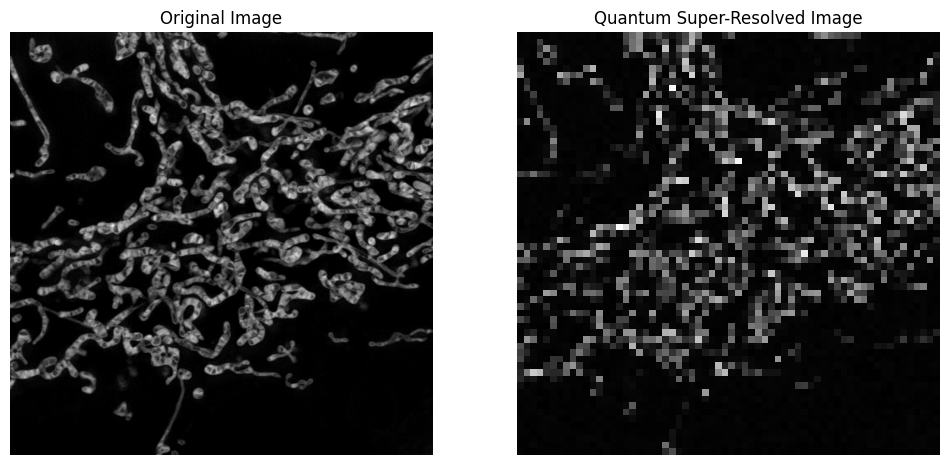

In [ ]:
# Compare Original vs Processed
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_gray, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(super_resolved[0].squeeze(), cmap="gray")
plt.title("Quantum Super-Resolved Image")
plt.axis("off")

plt.savefig(os.path.join(output_folder, "comparison_original_vs_quantum.png"))
plt.show()

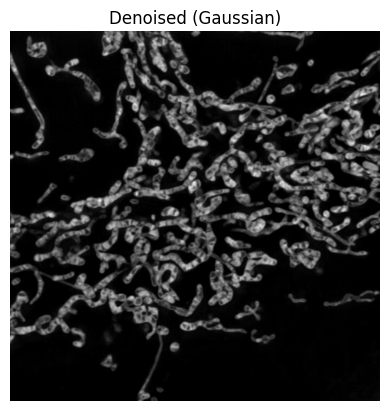

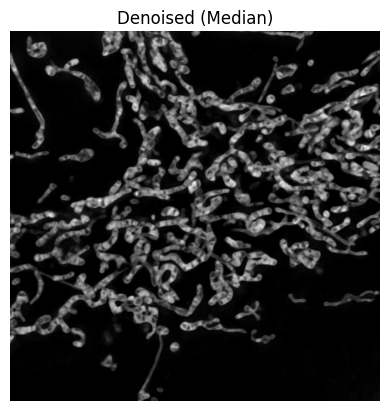

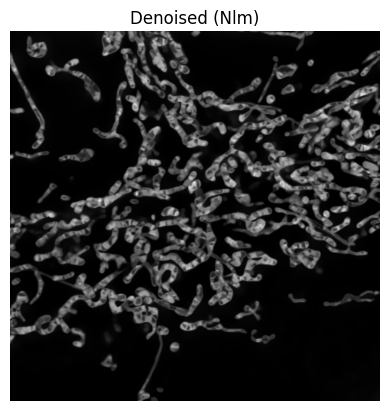

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tifffile
import os

# Ensure output directory
output_folder = "output_images"
os.makedirs(output_folder, exist_ok=True)

# Load TIFF Image
tiff_image_path = "converted_image.tiff"  # Update this to your file path
image_data = tifffile.imread(tiff_image_path)

# Convert to grayscale if necessary
if len(image_data.shape) > 2:
    image_gray = np.mean(image_data, axis=-1).astype(np.uint8)
else:
    image_gray = image_data

# Normalize image for better contrast
image_gray = cv2.normalize(image_gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Apply Advanced Denoising Techniques
image_gaussian = cv2.GaussianBlur(image_gray, (5, 5), 0)
image_median = cv2.medianBlur(image_gray, 5)
image_nlm = cv2.fastNlMeansDenoising(image_gray, None, 10, 7, 21)

# Save and Display Results
denoised_paths = {
    "gaussian": "denoised_gaussian.tiff",
    "median": "denoised_median.tiff",
    "nlm": "denoised_nlm.tiff"
}

for name, img in zip(denoised_paths.keys(), [image_gaussian, image_median, image_nlm]):
    tifffile.imwrite(os.path.join(output_folder, denoised_paths[name]), img)
    plt.imshow(img, cmap="gray")
    plt.title(f"Denoised ({name.capitalize()})")
    plt.axis("off")
    plt.show()

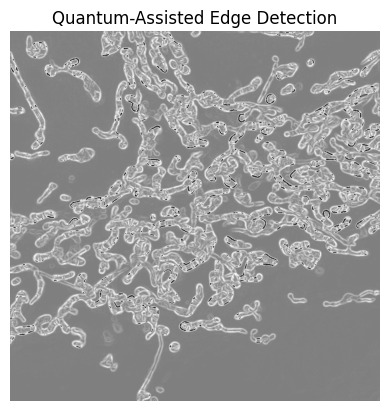

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

def quantum_edge_detection(image):
    """Applies a Quantum-Assisted Sobel Edge Detector"""
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    edge_map = np.hypot(sobel_x, sobel_y)
    edge_map = (edge_map / np.max(edge_map) * 255).astype(np.uint8)

    backend = AerSimulator()
    qc = QuantumCircuit(1, 1)
    qc.h(0)
    qc.measure(0, 0)

    job = backend.run(qc, shots=1024)
    result = job.result()
    counts = result.get_counts()
    quantum_noise_factor = int(counts.get("0", 0) / 1024 * 255)
    edge_map_quantum = np.clip(edge_map + quantum_noise_factor, 0, 255)

    return edge_map_quantum

# Apply Quantum-Assisted Edge Detection
quantum_edges = quantum_edge_detection(image_gaussian)

# Save & Display
edge_path = os.path.join(output_folder, "quantum_edge_detection.png")
plt.imsave(edge_path, quantum_edges, cmap="gray")
plt.imshow(quantum_edges, cmap="gray")
plt.title("Quantum-Assisted Edge Detection")
plt.axis("off")
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Lambda

# 🟢 Step 1: Prepare Classical Data
image_resized = cv2.resize(image_gray, (64, 64)) / 255.0
X_train = np.expand_dims(image_resized, axis=0)  # Add batch dimension
y_train = to_categorical([0], num_classes=2)

# 🟢 Step 2: Define Quantum Circuit
n_qubits = 4
qubits = [cirq.GridQubit(0, i) for i in range(n_qubits)]
params = [sympy.Symbol(f'theta_{i}') for i in range(n_qubits)]

def quantum_cnn_layer():
    """Quantum circuit with trainable parameters."""
    circuit = cirq.Circuit()
    for i, qubit in enumerate(qubits):
        circuit.append(cirq.rx(params[i])(qubit))  # Trainable RX rotation
        circuit.append(cirq.rz(params[i])(qubit))  # Trainable RZ rotation
    return circuit

# Convert Quantum Circuit to Tensor
quantum_circuit_tensor = tfq.convert_to_tensor([quantum_cnn_layer()])

# 🟢 Step 3: Define Measurement Operators
measurement_operators = [cirq.Z(qubit) for qubit in qubits]

# 🟢 Step 4: Fix the Model to Handle Quantum Input
model = Sequential([
    Input(shape=(64, 64, 1)),  # Classical Input
    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(16, activation="relu"),

    # Convert Classical Output to Quantum-Compatible Tensor
    Lambda(lambda x: tf.tile(quantum_circuit_tensor, [tf.shape(x)[0]])),

    # Quantum Processing Layer (Properly Linked to Measurement)
    tfq.layers.PQC(quantum_cnn_layer(), measurement_operators),

    Dense(2, activation="softmax")
])

# 🟢 Step 5: Train the Model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=500, verbose=1)

Epoch 1/500
1/1 [==============================] - 0s 408ms/step - loss: 0.5589 - accuracy: 1.0000
Epoch 2/500
1/1 [==============================] - 0s 7ms/step - loss: 0.5563 - accuracy: 1.0000
Epoch 3/500
1/1 [==============================] - 0s 5ms/step - loss: 0.5537 - accuracy: 1.0000
Epoch 4/500
1/1 [==============================] - 0s 5ms/step - loss: 0.5511 - accuracy: 1.0000
Epoch 5/500
1/1 [==============================] - 0s 5ms/step - loss: 0.5486 - accuracy: 1.0000
Epoch 6/500
1/1 [==============================] - 0s 5ms/step - loss: 0.5460 - accuracy: 1.0000
Epoch 7/500
1/1 [==============================] - 0s 7ms/step - loss: 0.5435 - accuracy: 1.0000
Epoch 8/500
1/1 [==============================] - 0s 7ms/step - loss: 0.5409 - accuracy: 1.0000
Epoch 9/500
1/1 [==============================] - 0s 8ms/step - loss: 0.5384 - accuracy: 1.0000
Epoch 10/500
1/1 [==============================] - 0s 6ms/step - loss: 0.5359 - accuracy: 1.0000
Epoch 11/500
1/1 [=========

Epoch 1/500


/home/administrator/anaconda3/envs/quantum/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 0s 376ms/step - loss: 0.1786
Epoch 2/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1783
Epoch 3/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1780
Epoch 4/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1777
Epoch 5/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1774
Epoch 6/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1770
Epoch 7/500
1/1 [==============================] - 0s 9ms/step - loss: 0.1767
Epoch 8/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1764
Epoch 9/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1761
Epoch 10/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1758
Epoch 11/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1754
Epoch 12/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1751
Epoch 13/500
1/1 [==============================] - 0s 6ms/step - loss:

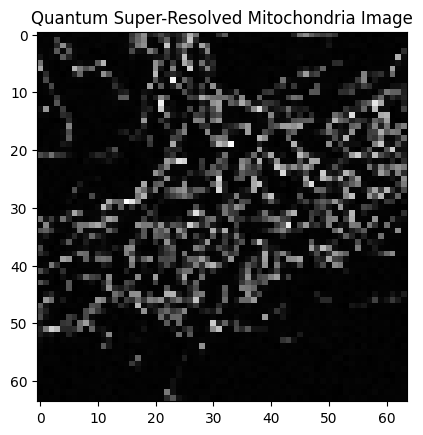

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os

# Define quantum encoder circuit with trainable parameters
def quantum_encoder():
    """Quantum Variational Encoder Circuit with trainable parameters"""
    qubits = [cirq.GridQubit(0, i) for i in range(4)]
    circuit = cirq.Circuit()
    params = [sympy.Symbol(f'theta_{i}') for i in range(4)]  # Trainable parameters

    for i, qubit in enumerate(qubits):
        circuit.append(cirq.rx(params[i])(qubit))
        circuit.append(cirq.rz(params[i])(qubit))

    return circuit

# Define measurement operators (Pauli Z expectation values)
measurement_operators = [cirq.Z(cirq.GridQubit(0, i)) for i in range(4)]

# Convert quantum circuit to TensorFlow Quantum tensor
quantum_circuit_tensor = tfq.convert_to_tensor([quantum_encoder()])

# Load preprocessed image
image_gray = tifffile.imread("denoised_image.tiff")

# Resize image for processing
image_resized = cv2.resize(image_gray, (64, 64)) / 255.0
X_train = np.expand_dims(image_resized, axis=0)  # Add batch dimension

# Build QVAE Model
input_image = tf.keras.layers.Input(shape=(64, 64, 1))
encoded = tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation="relu")(input_image)
encoded = tf.keras.layers.Flatten()(encoded)

# Convert classical output to quantum-compatible format
quantum_input = tf.keras.layers.Lambda(lambda x: tf.tile(quantum_circuit_tensor, [tf.shape(x)[0]]))(encoded)

# Apply PQC Layer
quantum_encoder_layer = tfq.layers.PQC(quantum_encoder(), measurement_operators)(quantum_input)

# Decoder
decoded = tf.keras.layers.Dense(64 * 64, activation="sigmoid")(quantum_encoder_layer)
decoded = tf.keras.layers.Reshape((64, 64, 1))(decoded)

# Compile QVAE Model
qvae = tf.keras.Model(input_image, decoded)
qvae.compile(optimizer="adam", loss="mse")

# Train the model
qvae.fit(X_train, X_train, epochs=500, verbose=1)

# Predict super-resolved image
super_resolved = qvae.predict(X_train)

# Save the output image
tifffile.imwrite("quantum_super_resolved.tiff", (super_resolved[0].squeeze() * 255).astype(np.uint8))

# Show result
plt.imshow(super_resolved[0].squeeze(), cmap="gray")
plt.title("Quantum Super-Resolved Mitochondria Image")
plt.savefig("quantum_super_resolved.png")
plt.show()

1/1 [==============================] - 0s 28ms/step


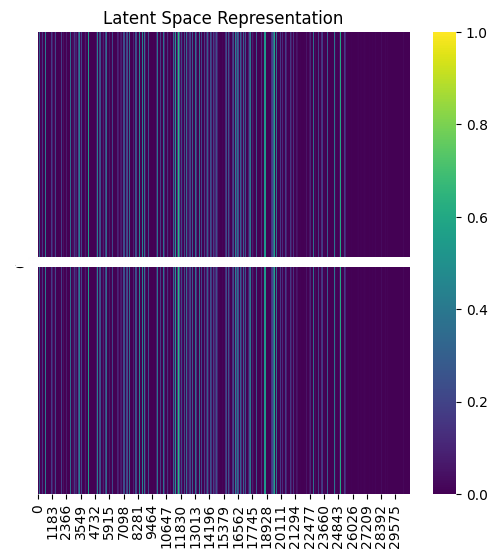

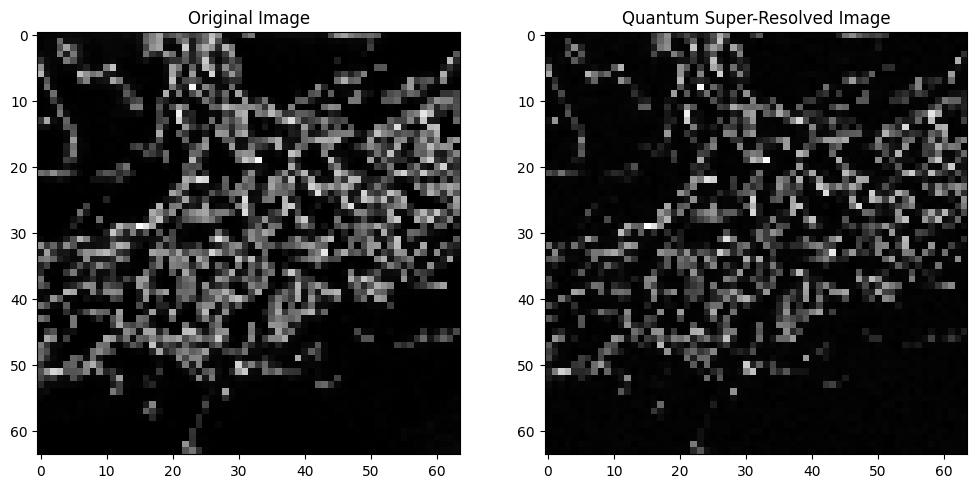

In [ ]:
import seaborn as sns

# Extract latent space representation
encoder = tf.keras.Model(inputs=qvae.input, outputs=qvae.get_layer(index=2).output)
latent_output = encoder.predict(X_train)

# Normalize for better visualization
latent_output = (latent_output - latent_output.min()) / (latent_output.max() - latent_output.min())

# Plot latent space heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(latent_output, cmap="viridis", annot=True)
plt.title("Latent Space Representation")
plt.savefig("latent_space_representation.png")
plt.show()

# Compare Original and Super-Resolved Image
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image_resized, cmap="gray")
axes[0].set_title("Original Image")

axes[1].imshow(super_resolved[0].squeeze(), cmap="gray")
axes[1].set_title("Quantum Super-Resolved Image")

plt.savefig("comparison_original_vs_quantum.png")
plt.show()